# Wczytanie danych

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [19]:
san = pd.read_csv('dane/san.csv', index_col=0, skiprows=2)
san['log_return'] = np.log1p(san.iloc[:,0].pct_change())
san = san.log_return
san.index = pd.to_datetime(san.index, format='%Y-%m-%d')
san.dropna(inplace=True)

# bonds = pd.read_csv('dane/obligacje10lat.csv', index_col=0, decimal=',')[::-1]
# bonds['log_return'] = np.log1p((bonds.iloc[:,0]).pct_change())
# bonds = bonds.log_return
# bonds.index = pd.to_datetime(bonds.index, format='%d.%m.%Y')

pln_eur = pd.read_csv('dane/pln_eur.csv', index_col=0, skiprows=2)
pln_eur['log_return'] = np.log1p(pln_eur.iloc[:,0].pct_change())
pln_eur = pln_eur.log_return
pln_eur.index = pd.to_datetime(pln_eur.index, format='%Y-%m-%d')
pln_eur.dropna(inplace=True)

etf = pd.read_csv('dane/etfbw20tr.csv', index_col=0)
etf['log_return'] = np.log1p(etf.Zamkniecie.pct_change())
etf = etf.log_return
etf.index = pd.to_datetime(etf.index)
etf.dropna(inplace=True)

# Wykresy zwrotów logarytmicznych

In [20]:
weights = np.array([0.5, 0.25, 0.25])
portfolio = san * weights[0] + etf * weights[1] + pln_eur * weights[2]
df = pd.concat([san, etf, pln_eur, portfolio], axis=1, join='outer').interpolate(method='linear', limit_direction='forward', axis=0).dropna()
df.columns = ['san', 'etf', 'eur/pln', 'portfolio']

In [21]:
df

,san,etf,eur/pln,portfolio
2020-01-03,-0.030555,-0.008060,-0.004003,-0.018293
2020-01-06,0.004762,-0.010137,0.000939,-0.015811
2020-01-07,-0.019185,-0.012213,-0.002733,-0.013329
2020-01-08,-0.002424,-0.014579,0.003589,-0.003960
2020-01-09,0.007255,0.020297,-0.003203,0.007901
...,...,...,...,...
2025-03-27,0.002890,0.002469,0.005120,0.003342
2025-03-28,-0.020409,-0.008764,0.000177,-0.012351
2025-03-31,-0.013343,-0.023034,-0.001938,-0.012915
2025-04-01,0.011870,0.016699,0.001364,0.010451


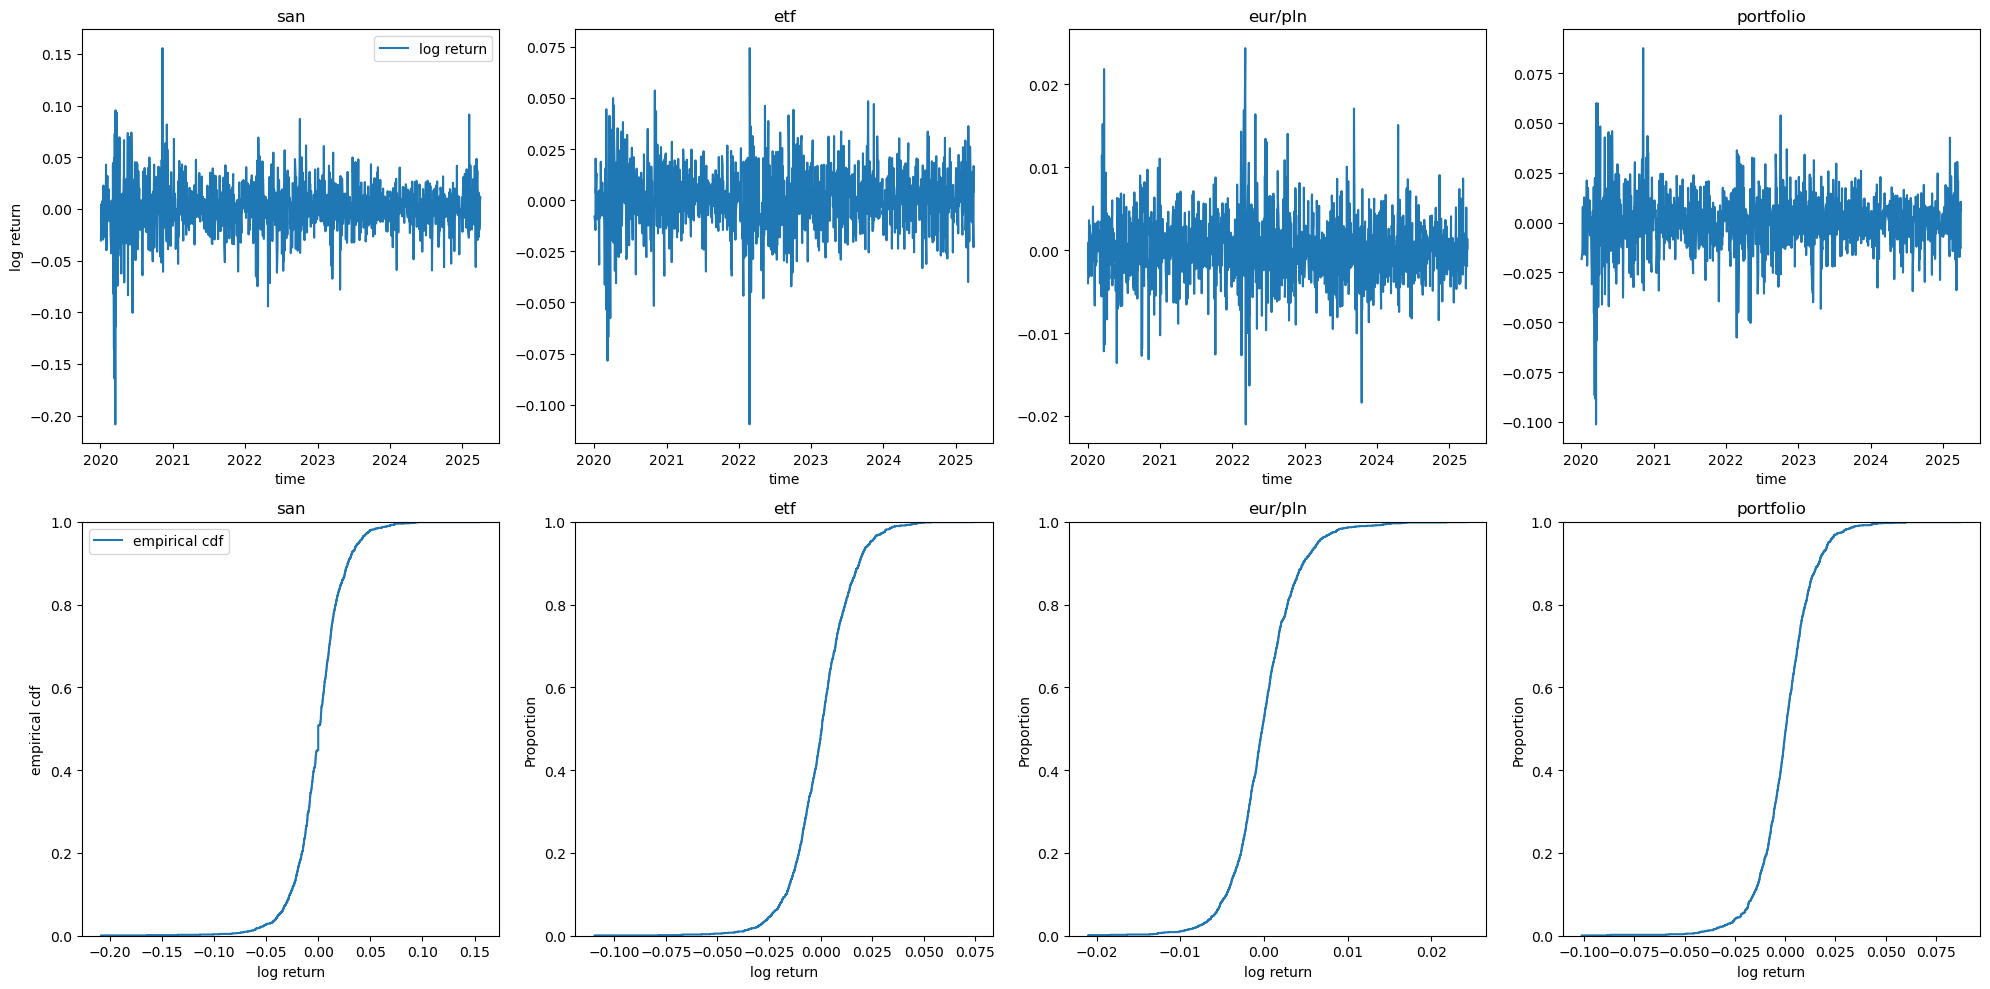

In [22]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs[0, 0].plot(df.index, df.san)
axs[0, 0].set_title('san')
axs[0, 1].plot(df.index, df.etf)
axs[0, 1].set_title('etf')
axs[0, 2].plot(df.index, df['eur/pln'])
axs[0, 2].set_title('eur/pln')
axs[0, 3].plot(df.index, df.portfolio)
axs[0, 3].set_title('portfolio')
sns.ecdfplot(df.san, ax=axs[1, 0])
axs[1, 0].set_title('san')
sns.ecdfplot(df.etf, ax=axs[1, 1])
axs[1, 1].set_title('etf')
sns.ecdfplot(df['eur/pln'], ax=axs[1, 2])
axs[1, 2].set_title('eur/pln')
sns.ecdfplot(df.portfolio, ax=axs[1, 3])
axs[1, 3].set_title('portfolio')
axs[0, 0].set_ylabel('log return')
axs[1, 0].set_ylabel('empirical cdf')
axs[0, 0].set_xlabel('time')
axs[0, 1].set_xlabel('time')
axs[0, 2].set_xlabel('time')
axs[0, 3].set_xlabel('time')
axs[1, 0].set_xlabel('log return')
axs[1, 1].set_xlabel('log return')
axs[1, 2].set_xlabel('log return')
axs[1, 3].set_xlabel('log return')
axs[0, 0].legend(['log return'])
axs[1, 0].legend(['empirical cdf'])
plt.tight_layout()

Text(0.5, 0.92, '3D scatter plot of log returns')

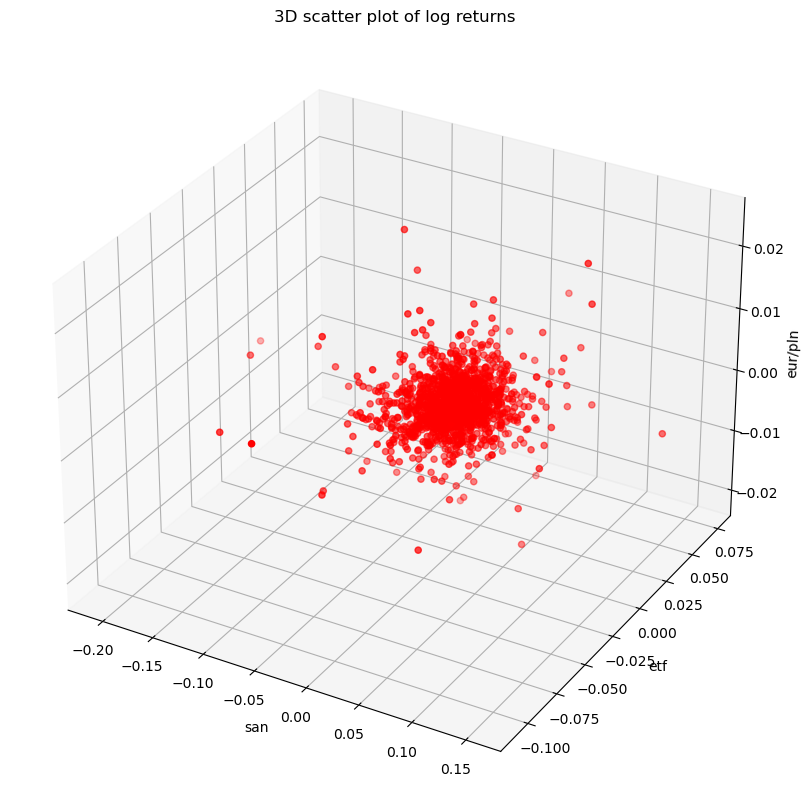

In [23]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.san, df.etf, df['eur/pln'], c='r', marker='o')
ax.set_xlabel('san')
ax.set_ylabel('etf')
ax.set_zlabel('eur/pln')
ax.set_title('3D scatter plot of log returns')

# Statystyki

In [24]:
def empirical_cdf(data, x):
    return np.sum(data <= x) / len(data)
def create_table(data):
    table = pd.DataFrame(index=['mean', 'std', 'mad', 'semi std', 'skew', 'kurt',
                                'q_0.05', 'q_0.5', 'q_0.75', 'q_0.95',
                                'ecdf(-1)', 'ecdf(-0.5)', 'ecdf(0)', 'ecdf(0.5)', 'ecdf(1)',
                               'ann vol'])
    for col in data.columns:
        table = pd.DataFrame(index=['mean', 'std', 'mad', 'semi std', 'skew', 'kurt',
                                'q_0.05', 'q_0.5', 'q_0.75', 'q_0.95',
                                'ecdf(-1)', 'ecdf(-0.5)', 'ecdf(0)', 'ecdf(0.5)', 'ecdf(1)',
                                'ann vol'])
    for col in data.columns:
        if col == 'portfolio':
            continue
        table[col] = [
            data[col].mean(),
            data[col].std(),
            mean_absolute_error(data[col], np.ones(data[col].size) * data[col].mean()),
            data[data[col] < data[col].mean()][col].std(),
            data[col].skew(),
            data[col].kurt(),
            data[col].quantile(0.05),
            data[col].quantile(0.5),
            data[col].quantile(0.75),
            data[col].quantile(0.95),
            empirical_cdf(data[col], -1),
            empirical_cdf(data[col], -.5),
            empirical_cdf(data[col], 0),
            empirical_cdf(data[col], .5),
            empirical_cdf(data[col], 1),
            str(round(np.sqrt(252) * data[col].std() * 100, 2)) + '%'
        ]
    port = data['portfolio']
    table['portfolio'] = [
        port.mean(),
        np.sqrt(weights.T @ df.iloc[:, :3].cov() @ weights),
        np.mean(np.abs(port - np.sum(df.iloc[:, :3].mean() * weights))),
        np.sqrt(weights.T @ df[df < 0].iloc[:, :3].cov() @ weights),
        port.skew(),
        port.kurt(),
        port.quantile(0.05),
        port.quantile(0.5),
        port.quantile(0.75),
        port.quantile(0.95),
        empirical_cdf(port, -1),
        empirical_cdf(port, -0.5),
        empirical_cdf(port, 0),
        empirical_cdf(port, 0.5),
        empirical_cdf(port, 1),
        str(round(np.sqrt(252) * np.sqrt(weights.T @ df.iloc[:, :3].cov() @ weights) * 100, 2)) + '%'
    ]

    return table
table = create_table(df)
table

,san,etf,eur/pln,portfolio
mean,0.000459,0.000324,-0.000013,0.000193
std,0.025192,0.015261,0.004085,0.014568
mad,0.017779,0.011301,0.002953,0.010287
semi std,0.019142,0.010802,0.002619,0.011232
skew,-0.620011,-0.399379,0.297742,-0.459212
kurt,7.263221,3.620483,3.85546,5.600927
q_0.05,-0.037703,-0.023745,-0.005943,-0.021821
q_0.5,0.0,0.000521,-0.000198,0.000397
q_0.75,0.013055,0.009074,0.002025,0.007753
q_0.95,0.039221,0.024009,0.006452,0.021549


# Kowariancja

In [25]:
df.cov()

,san,etf,eur/pln,portfolio
san,0.000635,0.000158,-4.594101e-06,3.467319e-04
etf,0.000158,0.000233,-3.747669e-06,1.334406e-04
eur/pln,-0.000005,-0.000004,1.668535e-05,9.145627e-07
portfolio,0.000347,0.000133,9.145627e-07,2.090769e-04


#### Dla ryzyka ekstremalnego (dla przynajmniej 1 zmiennej ryzyka):
a. Dopasuj rozkład graniczny maksimów lub warunkowych przekroczeń

# GEV

Text(0, 0.5, 'Pct. loss')

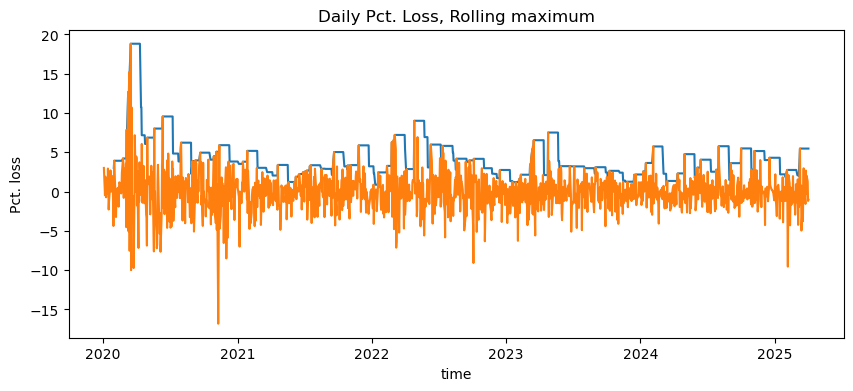

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
ls = 100 * (1 - np.exp(df.san))
# ls = 100 * (1 - np.exp(san))
rolling_max = ls.rolling(window=20).max()
plt.plot(df.index, rolling_max)
plt.plot(df.index, ls)
plt.plot()
plt.title('Daily Pct. Loss, Rolling maximum')
plt.xlabel('time')
plt.ylabel('Pct. loss')

In [94]:
from scipy.stats import genextreme, gumbel_r, weibull_max, invweibull, cramervonmises, kstest

n = 20
ls = 100 * (1 - np.exp(df.san))
ls = np.array_split(ls, len(ls) // n)
maxs = [np.max(x) for x in ls]

# fit gev
params_gev = genextreme.fit(maxs)

# fit gumbel
params_gumbel = gumbel_r.fit(maxs)

# fit weibull
params_weibull = weibull_max.fit(maxs, method='MM')

# fit frechet
params_frechet = invweibull.fit(maxs)

In [95]:
params_weibull

(14385.086193861009, 32681.453251894527, 32678.61242871311)

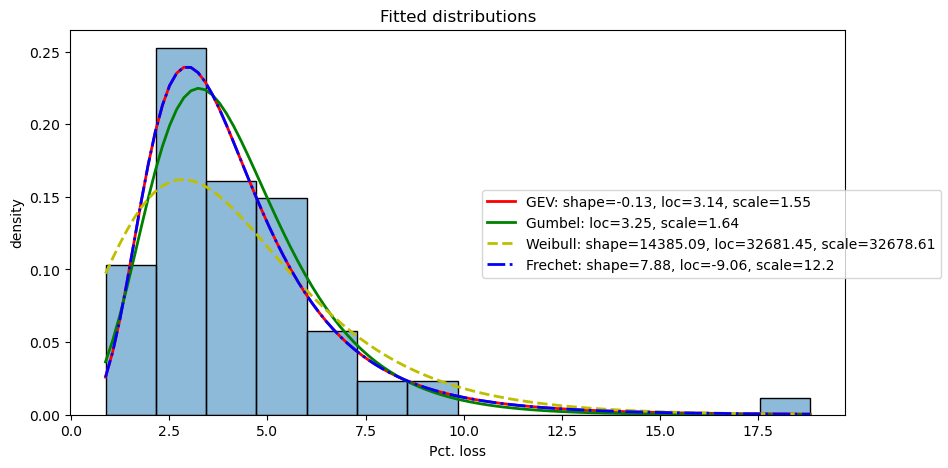

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
x = np.linspace(min(maxs), max(maxs), 100)
y = genextreme.pdf(x, *params_gev)
sns.histplot(maxs, stat='density', alpha=0.5, ax=ax)
ax.plot(x, y, 'r-', lw=2,
        label=f'GEV: shape={round(params_gev[0],2)}, loc={round(params_gev[1],2)}, scale={round(params_gev[2],2)}')
y = gumbel_r.pdf(x, *params_gumbel)
ax.plot(x, y, 'g-', lw=2,
        label=f'Gumbel: loc={round(params_gumbel[0],2)}, scale={round(params_gumbel[1],2)}')
y = weibull_max.pdf(x, *params_weibull)
ax.plot(x, y, 'y--', lw=2,
        label=f'Weibull: shape={round(params_weibull[0],2)}, loc={round(params_weibull[1],2)}, scale={round(params_weibull[2],2)}')
y = invweibull.pdf(x, *params_frechet)
ax.plot(x, y, 'b-.', lw=2,
        label=f'Frechet: shape={round(params_frechet[0],2)}, loc={round(params_frechet[1],2)}, scale={round(params_frechet[2],2)}')
ax.set_title('Fitted distributions')
ax.set_xlabel('Pct. loss')
ax.set_ylabel('density')
fig.legend(loc='right')

In [30]:
cramervonmises(maxs, genextreme.cdf, args=(params_gev))

CramerVonMisesResult(statistic=0.03204907240884601, pvalue=0.9698704662083518)

$H_0$ akceptowana $\implies$ dane pochodzą z tego rozkładu

In [31]:
cramervonmises(maxs, gumbel_r.cdf, args=(params_gumbel))

CramerVonMisesResult(statistic=0.049462524762168766, pvalue=0.8810949138125745)

$H_0$ akceptowana $\implies$ dane pochodzą z tego rozkładu

# Warunkowy rozkład przekroczenia

In [32]:
from scipy.stats import genpareto

Text(0, 0.5, 'Pct. Loss')

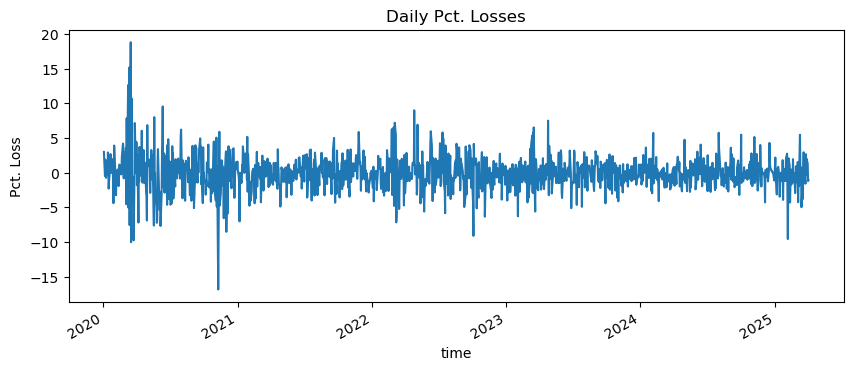

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
ls = 100 * (1 - np.exp(df.san))
ls.plot()
plt.title('Daily Pct. Losses')
plt.xlabel('time')
plt.ylabel('Pct. Loss')

In [34]:
def mean_excess(data, v):
    exceedances = data[data > v]
    return np.mean(exceedances - v)

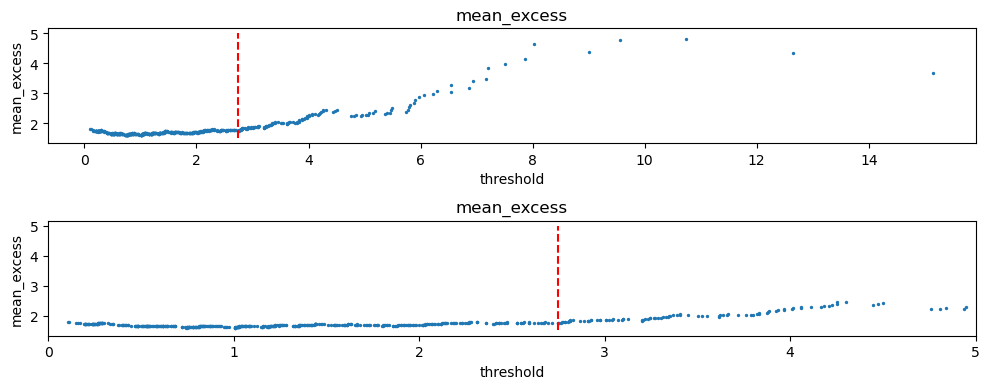

In [35]:
ls = ls[ls > 0]
fig, ax = plt.subplots(nrows=2)
fig.set_size_inches(10, 4)
ax[0].scatter(ls.sort_values(), [mean_excess(ls, l) for l in ls.sort_values()], s=2)
ax[0].vlines(2.75, 1.5, 5, 'red', 'dashed')
ax[0].set_title('mean_excess')
ax[0].set_ylabel('mean_excess')
ax[0].set_xlabel('threshold')
ax[1].set_title('mean_excess')
ax[1].set_ylabel('mean_excess')
ax[1].set_xlabel('threshold')
ax[1].scatter(ls.sort_values(), [mean_excess(ls, l) for l in ls.sort_values()], s=2)
ax[1].vlines(2.75, 1.5, 5, 'red', 'dashed')
ax[1].set_xlim(0, 5)
plt.tight_layout()

In [36]:
v = 2.75
Ys = ls[ls > v]
params = genpareto.fit(Ys)
params

(0.16340785304889857, 2.750497818385309, 1.4005063004540115)

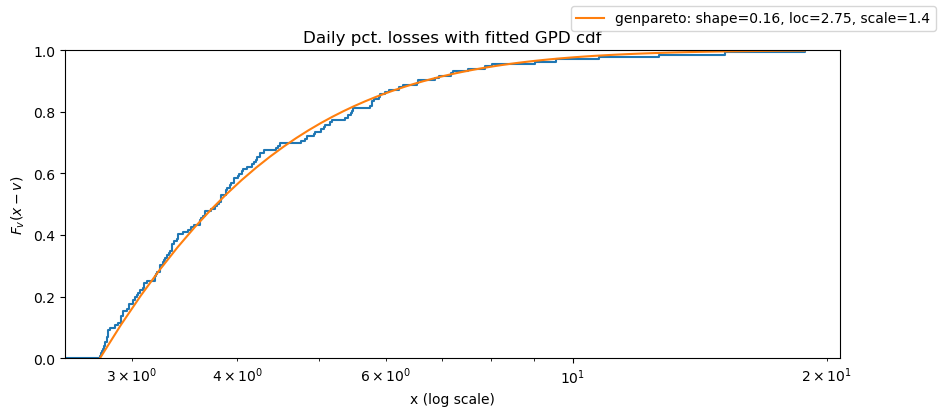

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
sns.ecdfplot(Ys, ax=ax)
x = np.linspace(min(Ys), max(Ys), 100)
ax.plot(x, genpareto.cdf(x, *params),
        label=f'genpareto: shape={round(params[0],2)}, loc={round(params[1],2)}, scale={round(params[2],2)}')
ax.set_xscale('log')
ax.set_xlabel('x (log scale)')
ax.set_ylabel('$F_v(x-v)$')
ax.set_title('Daily pct. losses with fitted GPD cdf')
fig.legend()

In [38]:
cramervonmises(Ys, genpareto.cdf, args=params)

CramerVonMisesResult(statistic=0.04197054395217498, pvalue=0.9234344301206839)

$H_0$ akceptowana $\implies$ dane pochodzą z tego rozkładu

In [39]:
# train _> params

In [40]:
params

(0.16340785304889857, 2.750497818385309, 1.4005063004540115)

In [41]:
# n = len(test)
# generuj n z tego rozkłądu o params
# porównaj test i wyegenerowane hist + qqplot + ftest